In [19]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml

#### Loading MNIST data set from openml

In [20]:
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [14]:
X, y = mnist['data'], mnist['target']

In [18]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


#### Take a deep look of the data set

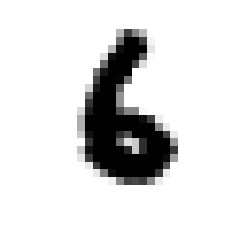

In [22]:
random_digit = X[36]
random_digit_image = random_digit.reshape(28, 28)
plt.imshow(random_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()